In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, time, shutil, sys
#from pathlib import Path
from glob import glob
from pprint import pprint
import numpy as np
import spikeinterface.full as si

sys.path.append("/home/phornauer/Git/axon_tracking/")
from axon_tracking import spike_sorting as ss
from axon_tracking import template_extraction as te

Specify sorter and sorter parameters

In [3]:
sorter = 'kilosort2_5'
si.Kilosort2_5Sorter.set_kilosort2_5_path('/home/phornauer/Git/Kilosort_2020b') #Change
sorter_params = si.get_default_sorter_params(si.Kilosort2_5Sorter)
sorter_params['n_jobs'] = -1
sorter_params['detect_threshold'] = 7
sorter_params['minFR'] = 0.01
sorter_params['minfr_goodchannels'] = 0.01
sorter_params['keep_good_only'] = False
sorter_params['do_correction'] = False
#pprint(sorter_params)

Setting KILOSORT2_5_PATH environment variable for subprocess calls to: /home/phornauer/Git/Kilosort_2020b


In [4]:
rec_path = "/net/bs-filesvr02/export/group/hierlemann/intermediate_data/Mea1k/jbartram/Mea1k_slice_UDS_TalCollab/230711/rec5.raw.h5"

In [6]:
save_path_changes = {'pos': [0, 6, 7, 8, 9, 10, 11], 'vals': ['/', 'intermediate_data', 'Mea1k', 'phornauer', 'Slices','230711','Rec5','']}

save_path = ss.convert_rec_path_to_save_path(rec_path, save_path_changes)
    
print(f'The save path corresponds to the pattern:\n {save_path}\n')

The save path corresponds to the pattern:
 /net/bs-filesvr02/export/group/hierlemann/intermediate_data/Mea1k/phornauer/Slices/230711/Rec5



In [8]:
stream_id = ss.get_stream_ids(rec_path)[0]

In [ ]:

rec = si.MaxwellRecordingExtractor(rec_path, stream_id=stream_id)

sorting = ss.clean_sorting(rec, save_path, stream_id, sorter, sorter_params)

In [13]:
te_params = dict()
te_params['align_cutout'] = True #Align waveforms by max waveform peak
te_params['upsample'] = 2 #Factor by which to upsample waveforms
te_params['rm_outliers'] = True #Check if outliers should be removed
te_params['n_jobs'] = 16 #Number of cores to use for waveform extraction
te_params['n_neighbors'] = 10 #Number of neighbors for outlier detection
te_params['peak_cutout'] = 2 #Looking for peak +- this value around the expected peak (removing minor offsets)
te_params['overwrite_wf'] = True #Flag if waveform extraction should be repeated (e.g. different cutouts)
te_params['overwrite_tmp'] = True #Flag if templates should be recalculated if already existing
te_params['filter_flag'] = True #Flag if filtering should be applied

qc_params = dict()
qc_params['min_n_spikes'] = 500 #Minimum number of spikes to be detected for a unit for template extraction to take place
qc_params['exclude_mua'] = True #Exclude units that were labelled multi unit activity by kilosort

In [9]:
sorting_path = os.path.join(save_path,stream_id)
json_path = os.path.join(sorting_path, 'spikeinterface_recording.json')
multirecording = si.load_extractor(json_path, base_folder=True)

In [23]:
sorting_list = [os.path.join(save_path,stream_id)]
te.extract_templates_from_sorting_list(sorting_list, qc_params, te_params)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:01<?, ?it/s]


TypeError: 'recording_or_recording_list' must be a list of recordings, ConcatenateSegmentRecording, or None

In [10]:
output_path = os.path.join(sorting_path,'sorter_output')
sorting = si.KiloSortSortingExtractor(output_path)
json_path = os.path.join(sorting_path, 'spikeinterface_recording.json')
multirecording = si.load_extractor(json_path, base_folder=True)
rec_path = ss.get_recording_path(multirecording)
stream_id = [p for p in sorting_path.split('/') if p.startswith('well')][0] #Find out which well this belongs to

rec_names, common_el, pos = ss.find_common_electrodes(rec_path, stream_id)
cleaned_sorting = te.select_good_units(sorting, **qc_params)
cleaned_sorting = si.remove_excess_spikes(cleaned_sorting, multirecording) #Relevant if last spike time == recording_length
cleaned_sorting.register_recording(multirecording)

In [65]:
seg_we = si.load_waveforms(os.path.join(sorting_path, 'waveforms', 'seg' + str(0)), sorting = cleaned_sorting)

In [92]:
wfs = seg_we.get_waveforms(sel_unit_id)
wfs.shape

(600, 130, 767)

In [83]:
mean_wf = np.mean(wfs,axis=0)
mean_wf.shape

(130, 767)

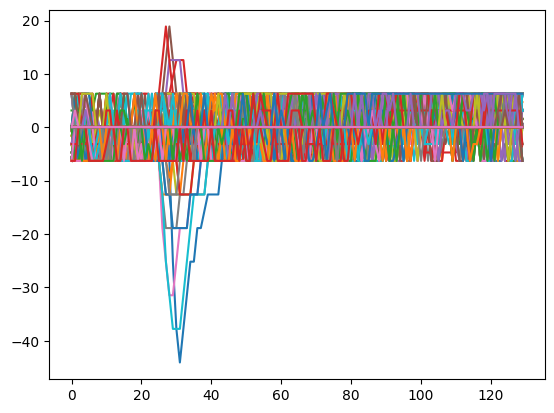

In [87]:
plt.plot(mean_wf - np.median(mean_wf, axis=0)[np.newaxis,:])
plt.show()

In [ ]:
si.bandpass_filter()

In [14]:
save_root = sorting_path
sel_unit_ids = cleaned_sorting.get_unit_ids()
sel_unit_id = sel_unit_ids[10]
template_matrix, noise_levels = te.combine_templates(stream_id, cleaned_sorting, sel_unit_id, save_root, **te_params)

Network recording detected, using default [1.5, 5]


extract waveforms memmap multi buffer:   0%|          | 0/2045 [00:00<?, ?it/s]

In [94]:
grid = te.convert_to_grid(template_matrix, pos)

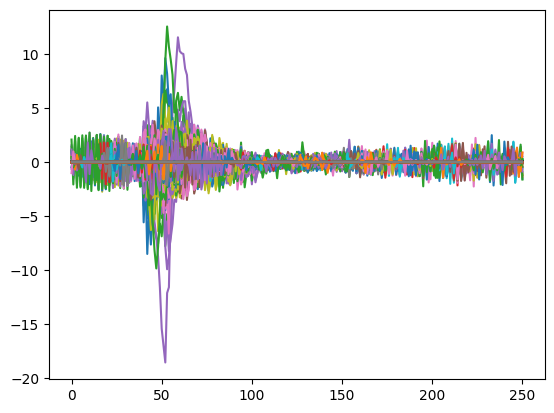

In [16]:
import matplotlib.pyplot as plt
plt.plot(np.diff(template_matrix,axis=0))
plt.show()

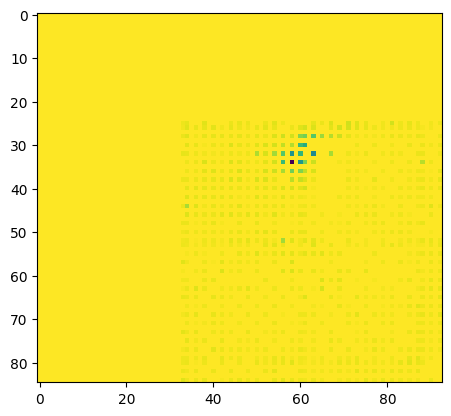

In [96]:
plt.imshow(np.min(grid,axis=2))
plt.show()

In [44]:
te.extract_all_templates(stream_id, cleaned_sorting, sorting_path, pos, te_params)

100%|██████████| 214/214 [00:00<00:00, 1220.20it/s]

Unit 10 encountered the following error:
 negative dimensions are not allowed
Unit 22 encountered the following error:
 negative dimensions are not allowed
Unit 27 encountered the following error:
 negative dimensions are not allowed
Unit 31 encountered the following error:
 negative dimensions are not allowed
Unit 52 encountered the following error:
 negative dimensions are not allowed
Unit 71 encountered the following error:
 negative dimensions are not allowed
Unit 75 encountered the following error:
 negative dimensions are not allowed
Unit 77 encountered the following error:
 negative dimensions are not allowed
Unit 78 encountered the following error:
 negative dimensions are not allowed
Unit 95 encountered the following error:
 negative dimensions are not allowed
Unit 96 encountered the following error:
 negative dimensions are not allowed
Unit 101 encountered the following error:
 negative dimensions are not allowed
Unit 108 encountered the following error:
 negative dimensions 